# Intro

We will be working with the data from [NHANES](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2017), which is the the National Health and Nutrition Examination Survey, conducted by the National Center for Health Statistics (USA). 

They follow up the survey participants for 2 years and also ask relevant demographic and dietary questions and also life-style related.

For each study (they are made every two years), we find data about:
- demographics
- diet
- examination
- laboratory
- questionnaire (mainly lifestyle related)

With this data we will try to predict a few diseases such as heart diseases or asthma.

As the data is quite noise, full of NaNs, etc... I took the surveys from several year-pairs:
- 2013-2014
- 2015-2016
- 2017-2018

This should be no problem, as it isn't a temporal serie. The survey methods can be consulted in the website.

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

import os, sys

# Helpers
abspath = os.path.abspath
dirname = os.path.dirname
sep = os.sep
file_ = os.getcwd()

ml_folder = dirname(file_)
sys.path.append(ml_folder)

from src.utils import mining_data_tb as md
from src.utils import visualization_tb as vi
from src.utils import folder_tb as fo


import warnings

warnings.filterwarnings("ignore")

## Data exploration

In [2]:
# As the data variables are coded (for instance, "RIAGENDR" is Gender), we first need to load the variable descriptions. For that, we will create an object with all the info and methods to change names whenever necessary

# 1) We create the object
vardata = md.variables_data()

# 2) We load the info
vardata_path = "data" + sep + "6_variables" + sep + "0_final_variables.csv"
vardata.load_data(2, vardata_path)

In [3]:
# Now we can load the actual dataset we will be using for the ml models

# 1) Create object
dataset = md.dataset()

# 2) Load data
folders = ["1_demographics", "2_dietary", "3_examination", "4_laboratory", "5_questionnaire"]
dataset.load_data(2, folders)

# 3) Clean duplicated columns (alraedy have them detected)
columns_correction = {
            "WTDRD1_x" : "WTDRD1",
            "WTDR2D_x" : "WTDR2D",
            "DRABF_x" : "DRABF",
            "DRDINT_x" : "DRDINT",
            "WTSAF2YR_x" : "WTSAF2YR",
            "LBXHCT_x" : "LBXHCT"
        }
dataset.clean_columns(columns_correction)

# 4) Add heart heart_disease -> It creates a new column where if participant has any cardiovascular disease (angina, stroke, etc...), it will have a 1 and 0 otherwise
dataset.heart_disease()

In [4]:
### DON'T EXECUTE THIS ONE

# Before doing any cleaning or transformation, let's save this dataset
#path_to_save = ml_folder + sep + "data" + sep + "7_cleaned_data" + sep + "raw_data.csv"
#dataset.df.to_csv(path_to_save)

In [5]:
# With this, we can do a first exploration. For that, we can access the df though the object attribute "df"

print(dataset.df.shape, "\n")
dataset.df.head(2)

(29213, 951) 



,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,SMQ690F,SMQ830,SMQ840,SMDANY,SMAQUEX,SMQ690I,SMQ857,SMQ690J,SMQ861,MCQ160H
SEQN,,,,,,,,,,,,,,,,,,,,,
83732,9,2,1,62,NaN,3,3,1.0,NaN,2.0,...,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,0
83733,9,2,1,53,NaN,3,3,1.0,NaN,2.0,...,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,0


In [6]:
dataset.df.MCQ160H.value_counts()

0    27371
1     1842
Name: MCQ160H, dtype: int64

In [7]:
# As we can see, it is quite wide. Let's filter by the columns we will actually be using (using our magnificent object)
features = ["MCQ010", "RIAGENDR", "RIDAGEYR", "DR1TCHOL", "DR1TTFAT", "DR1TSFAT", "DR1TSUGR", "DR2TCHOL", "DR2TTFAT", "DR2TSFAT", "DR2TSUGR", "BPXDI1", "BPXSY1", "BMXWT", "DXDTOPF", "BMXWAIST", "LBXTR", "LBXTC", "LBXSGL"]

dataset.filter_columns(features, inplace = True)

In [8]:
print(dataset.df.shape)

dataset.df.info()

(29213, 19)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29213 entries, 83732 to 102956
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MCQ010    28054 non-null  float64
 1   RIAGENDR  29213 non-null  int64  
 2   RIDAGEYR  29213 non-null  int64  
 3   DR1TCHOL  24186 non-null  float64
 4   DR1TTFAT  24186 non-null  float64
 5   DR1TSFAT  24186 non-null  float64
 6   DR1TSUGR  24186 non-null  float64
 7   DR2TCHOL  20705 non-null  float64
 8   DR2TTFAT  20705 non-null  float64
 9   DR2TSFAT  20705 non-null  float64
 10  DR2TSUGR  20705 non-null  float64
 11  BPXDI1    20466 non-null  float64
 12  BPXSY1    20466 non-null  float64
 13  BMXWT     27574 non-null  float64
 14  DXDTOPF   13272 non-null  float64
 15  BMXWAIST  24419 non-null  float64
 16  LBXTR     8624 non-null   float64
 17  LBXTC     21457 non-null  float64
 18  LBXSGL    18552 non-null  float64
dtypes: float64(17), int64(2)
memory usage: 4.5 MB


In [9]:
# Since que can't pass NaN values to the model, we need to do some transformation or drop some values here
# Let's get some more info about the data before doing anything

dataset.df.describe()

,MCQ010,RIAGENDR,RIDAGEYR,DR1TCHOL,DR1TTFAT,DR1TSFAT,DR1TSUGR,DR2TCHOL,DR2TTFAT,DR2TSFAT,DR2TSUGR,BPXDI1,BPXSY1,BMXWT,DXDTOPF,BMXWAIST,LBXTR,LBXTC,LBXSGL
count,28054.000000,29213.000000,29213.000000,24186.000000,24186.000000,24186.000000,24186.000000,20705.000000,20705.000000,20705.000000,20705.000000,20466.000000,20466.000000,27574.000000,13272.000000,24419.000000,8624.000000,21457.000000,18552.000000
mean,1.847687,1.509054,32.342895,267.568469,76.938708,25.458654,106.280634,257.322338,70.498384,23.432803,97.156071,66.545783,119.847454,63.251462,32.062967,88.259249,108.876971,179.887123,101.747844
std,0.359331,0.499927,24.828824,234.045424,45.577694,16.273312,70.781600,221.094807,41.618728,15.234315,62.966646,15.192569,18.865584,32.560457,8.598014,22.739996,103.197779,40.943273,37.996146
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.000000,3.100000,11.700000,40.000000,10.000000,69.000000,19.000000
25%,2.000000,1.000000,10.000000,111.000000,45.192500,14.261500,59.422500,107.000000,41.550000,13.046000,55.070000,58.000000,106.000000,38.800000,25.600000,72.000000,58.000000,150.000000,86.000000
50%,2.000000,2.000000,28.000000,198.000000,67.980000,22.017000,91.870000,194.000000,62.310000,20.227000,85.370000,68.000000,116.000000,66.100000,31.800000,89.200000,87.000000,175.000000,93.000000
75%,2.000000,2.000000,54.000000,358.000000,98.147500,32.812500,135.652500,342.000000,90.540000,30.237000,124.810000,76.000000,130.000000,84.300000,38.800000,103.800000,131.000000,204.000000,103.000000
max,2.000000,2.000000,80.000000,3515.000000,567.960000,223.759000,1115.500000,2666.000000,530.220000,259.210000,903.200000,136.000000,236.000000,242.600000,56.100000,177.900000,4233.000000,813.000000,626.000000


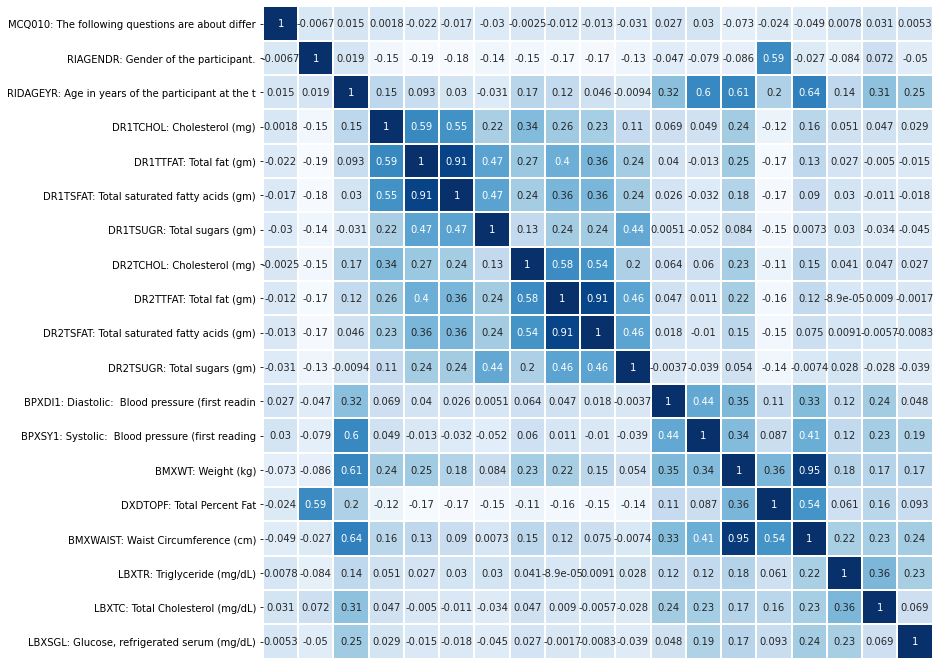

In [10]:
# Correlations

# Saving the variable descriptions for a better understanding of the data
features_names = vardata.vars_descr_detector(list(dataset.df.columns), 40, True)

plt.figure(figsize = (12, 12))
sns.heatmap(dataset.df.corr(), annot = True, linewidths = .1, cmap = "Blues", xticklabels = False, yticklabels = features_names, cbar = False)
plt.show()

In [11]:
# MCQ010 (first one in the matrix) is out target value (asthma in this case)
# Let's check the variable

dataset.df.MCQ010.value_counts()

2.0    23781
1.0     4273
Name: MCQ010, dtype: int64

In [12]:
# 2 -> Never had asthma     -> we'll change this 0 as it's going to be the negative for our model predictions
# 1 -> he/she has asthma
# 9 and 7 -> no answer or didnt know (we'll drop these values)

dataset.df = dataset.df[(dataset.df.MCQ010 != 7) & (dataset.df.MCQ010 != 9)]
dataset.df.MCQ010 = dataset.df.MCQ010.replace(2, 0)
dataset.df.MCQ010.value_counts()

0.0    23781
1.0     4273
Name: MCQ010, dtype: int64

In [13]:
# Great! That's more like it
# Now: let's check the outliers

In [14]:
features_names[1:]

['RIAGENDR: Gender of the participant.',
 'RIDAGEYR: Age in years of the participant at the t',
 'DR1TCHOL: Cholesterol (mg)',
 'DR1TTFAT: Total fat (gm)',
 'DR1TSFAT: Total saturated fatty acids (gm)',
 'DR1TSUGR: Total sugars (gm)',
 'DR2TCHOL: Cholesterol (mg)',
 'DR2TTFAT: Total fat (gm)',
 'DR2TSFAT: Total saturated fatty acids (gm)',
 'DR2TSUGR: Total sugars (gm)',
 'BPXDI1: Diastolic:  Blood pressure (first readin',
 'BPXSY1: Systolic:  Blood pressure (first reading',
 'BMXWT: Weight (kg)',
 'DXDTOPF: Total Percent Fat',
 'BMXWAIST: Waist Circumference (cm)',
 'LBXTR: Triglyceride (mg/dL)',
 'LBXTC: Total Cholesterol (mg/dL)',
 'LBXSGL: Glucose, refrigerated serum (mg/dL)']

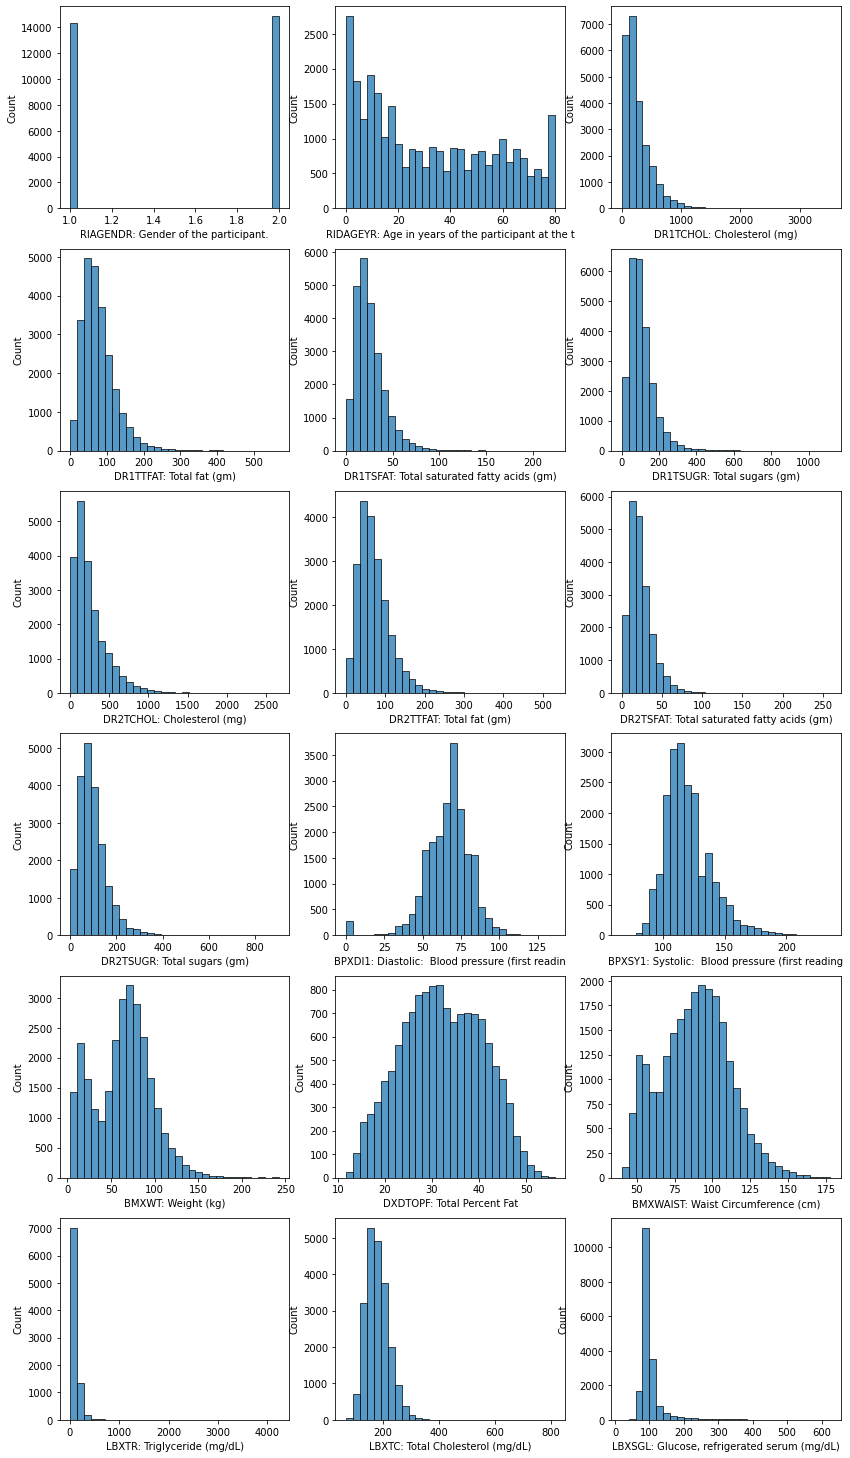

In [15]:
# Let's do some plotting for the independent variables

fig = vi.multi_axes_plotter(dataset.df.iloc[:, 1:], 3, "stripplot", (14, 26), features_names[1:])

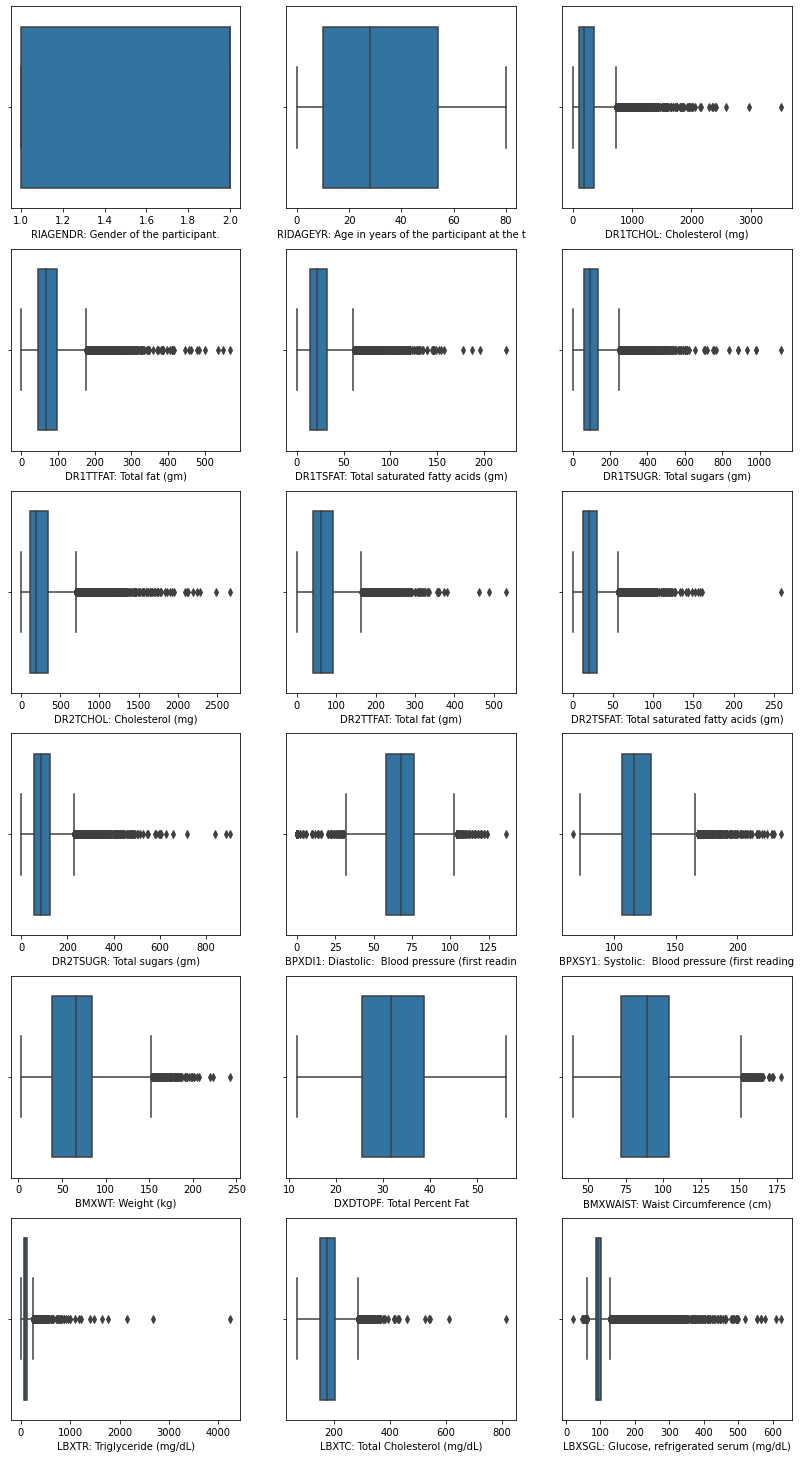

In [16]:
fig = vi.multi_axes_plotter(dataset.df.iloc[:, 1:], 3, "box", (14, 26), features_names[1:])

In [17]:
# Well, we have quite a few outliers
# To keep in mind: since some of the independent variables are highly correlated, it's likely for them to have the same observations as outliers. For instance, DR1TTFAT and DR1STFAT are likely to have same participants as outliers
# So, by removing the outliers from one of the correlated columns, we are cleaning the other one at the same time

DR1TTFAT_outliers = dataset.df[dataset.df.DR1TTFAT > 200]

print("shape:", DR1TTFAT_outliers.shape)
print("\nTarget values:")
print(DR1TTFAT_outliers.iloc[:, 0].value_counts())
print("\nNaNs:")
print(DR1TTFAT_outliers.isna().sum())

shape: (458, 19)

Target values:
0.0    373
1.0     85
Name: MCQ010, dtype: int64

NaNs:
MCQ010        0
RIAGENDR      0
RIDAGEYR      0
DR1TCHOL      0
DR1TTFAT      0
DR1TSFAT      0
DR1TSUGR      0
DR2TCHOL     66
DR2TTFAT     66
DR2TSFAT     66
DR2TSUGR     66
BPXDI1       38
BPXSY1       38
BMXWT         4
DXDTOPF     149
BMXWAIST     10
LBXTR       269
LBXTC        27
LBXSGL       44
dtype: int64


In [18]:
# As we can see, there are quite a few positive cases (MCQ010 == 1) within the fat outliers. This means, by removing the outliers we would also remove valuable information for our model to detect when someone is likely to have asthma.

# We have to keep in mind that our data is already quite imbalanced, so the more positive target values we keep, the better.

# Let's do a simple calculation to see if it's worth to remove the outliers here mentioned.
# The ratio of positive/data in out full dataset is = 4278 / (4278 + 23819) ~ 0.15225

# If the ratio in the outliers is below that number, it would mean that we are removing more negative than positive ones, so it could be worth. However, for this batch this is not the case:
# 85 / (374 + 85) ~ 0.18518

In [19]:
# Let's check blood pressure

BPXDI1_outliers = dataset.df[(dataset.df.BPXDI1 < 26) | (dataset.df.BPXDI1 > 105)]

print("shape:", BPXDI1_outliers.shape)
print("\nTarget values:")
print(BPXDI1_outliers.iloc[:, 0].value_counts())
print("\nNaNs:")
print(BPXDI1_outliers.isna().sum())

shape: (391, 19)

Target values:
0.0    325
1.0     66
Name: MCQ010, dtype: int64

NaNs:
MCQ010        0
RIAGENDR      0
RIDAGEYR      0
DR1TCHOL     61
DR1TTFAT     61
DR1TSFAT     61
DR1TSUGR     61
DR2TCHOL    104
DR2TTFAT    104
DR2TSFAT    104
DR2TSUGR    104
BPXDI1        0
BPXSY1        0
BMXWT         6
DXDTOPF     145
BMXWAIST     18
LBXTR       293
LBXTC        42
LBXSGL      184
dtype: int64


In [20]:
# Here we have a similar case as before: we'd be removing more positive than negative labels:
# 66 / (327 + 66) ~ 0.1679

In [21]:
# Well, we have quite a few outliers
# To keep in mind: since some of the independent variables are highly correlated, it's likely for them to have the same observations as outliers. For instance, DR1TTFAT and DR1STFAT are likely to have same participants as outliers
# So, by removing the outliers from one of the correlated columns, we are cleaning the other one at the same time

LBXSGL_outliers = dataset.df[dataset.df.LBXSGL > 150]

print("shape:", LBXSGL_outliers.shape)
print("\nTarget values:")
print(LBXSGL_outliers.iloc[:, 0].value_counts())
print("\nNaNs:")
print(LBXSGL_outliers.isna().sum())

shape: (1097, 19)

Target values:
0.0    921
1.0    176
Name: MCQ010, dtype: int64

NaNs:
MCQ010        0
RIAGENDR      0
RIDAGEYR      0
DR1TCHOL    114
DR1TTFAT    114
DR1TSFAT    114
DR1TSUGR    114
DR2TCHOL    240
DR2TTFAT    240
DR2TSFAT    240
DR2TSUGR    240
BPXDI1       98
BPXSY1       98
BMXWT        27
DXDTOPF     717
BMXWAIST     98
LBXTR       592
LBXTC         0
LBXSGL        0
dtype: int64


In [22]:
# Same as previous examples 176 / (928 + 176) ~ 0.1594

In [23]:
# We will see how the models work with the data as it is
# Now, let's remove the NaNs to avoid issues with the model

dataset.df = dataset.df.drop(["LBXTR", "DXDTOPF"], axis = 1)
dataset.df = dataset.df.dropna()
dataset.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13446 entries, 83732 to 102956
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MCQ010    13446 non-null  float64
 1   RIAGENDR  13446 non-null  int64  
 2   RIDAGEYR  13446 non-null  int64  
 3   DR1TCHOL  13446 non-null  float64
 4   DR1TTFAT  13446 non-null  float64
 5   DR1TSFAT  13446 non-null  float64
 6   DR1TSUGR  13446 non-null  float64
 7   DR2TCHOL  13446 non-null  float64
 8   DR2TTFAT  13446 non-null  float64
 9   DR2TSFAT  13446 non-null  float64
 10  DR2TSUGR  13446 non-null  float64
 11  BPXDI1    13446 non-null  float64
 12  BPXSY1    13446 non-null  float64
 13  BMXWT     13446 non-null  float64
 14  BMXWAIST  13446 non-null  float64
 15  LBXTC     13446 non-null  float64
 16  LBXSGL    13446 non-null  float64
dtypes: float64(15), int64(2)
memory usage: 1.8 MB


In [25]:
### DON'T EXECUTE THIS ONE

# We will take this dataset as it is and save it as our cleaned data, because it's the one we'll be using for ML and neural networks

#path_to_save = ml_folder + sep + "data" + sep + "7_cleaned_data" + sep + "cleaned_data.csv"
#dataset.df.to_csv(path_to_save)

## ML Models and Predictions

### Logistic Regression

In [26]:
# Let's prepare the data and choose a model

# 1) Prepare data for ml models
# For this, we have an useful method in our dataset object. We'll try a basic split and validation, without making any further change to the data (for this attempt)
dataset.model_data(split = .2, cv = 5, epochs = 1)

# 2) Choose model
model = LogisticRegression(n_jobs = -1, max_iter = 300)

# 3) We create a ml_model object and load the data
my_model = md.ml_model(model)

# Load data
my_model.load_data(dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test, features_names, dataset.kfold)

# 4) We train the model
my_model.ml_trainer()

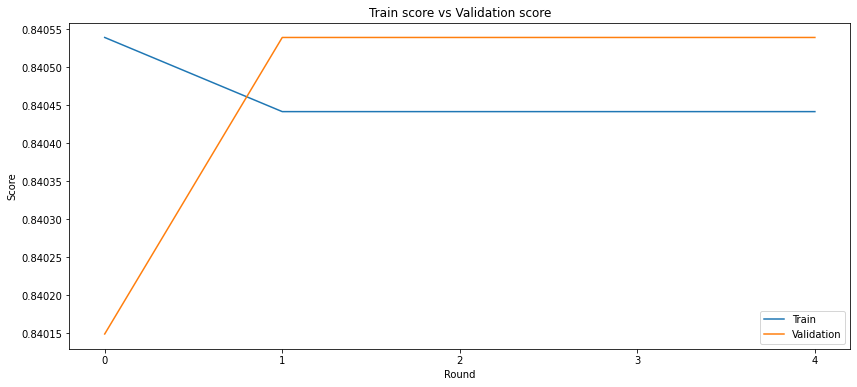

In [27]:
# Let's plot the results

plt.figure(figsize = (14, 6))
plt.plot(my_model.train_scores, label = "Train")
plt.plot(my_model.val_scores, label = "Validation")
plt.ylabel("Score")
plt.xlabel("Round")
plt.xticks(range(5))
plt.title("Train score vs Validation score")
plt.legend()
plt.show()

In [28]:
# We see that the score doesn't vary much through the rounds
# Let's check the structure of batches for each round (how many positive and negative labels had each)

print("Train batches")
for item in my_model.train_set_structures: print(item)

print("#" * 75)

print("Validation batches")
for item in my_model.val_set_structures: print(item)

Train batches
{0.0: 0.8405392840539284, 1.0: 0.15946071594607159}
{0.0: 0.8404416037187682, 1.0: 0.15955839628123183}
{0.0: 0.8404416037187682, 1.0: 0.15955839628123183}
{0.0: 0.8404416037187682, 1.0: 0.15955839628123183}
{0.0: 0.8404416037187682, 1.0: 0.15955839628123183}
###########################################################################
Validation batches
{0.0: 0.8401486988847584, 1.0: 0.15985130111524162}
{0.0: 0.8405392840539284, 1.0: 0.15946071594607159}
{0.0: 0.8405392840539284, 1.0: 0.15946071594607159}
{0.0: 0.8405392840539284, 1.0: 0.15946071594607159}
{0.0: 0.8405392840539284, 1.0: 0.15946071594607159}


In [29]:
# We see that thanks for the StratifiedKFold, the positive-negative proportion remains constant through the validation rounds

In [30]:
# Let's see how the model does with the test data
my_model.ml_tester()

In [31]:
print("Train structure:", my_model.train_structure)
print("Test structure:", my_model.test_structure)
print("#" * 50)
print("Train score:", my_model.train_score)
print("Test score:", my_model.test_score)
print("#" * 50)
print("Confusion matrix")
print(my_model.cm)

Train structure: {0.0: 84.04611379695054, 1.0: 15.95388620304946}
Test structure: {0.0: 84.1263940520446, 1.0: 15.87360594795539}
##################################################
Train score: 0.8404611379695054
Test score: 0.8412639405204461
##################################################
Confusion matrix
[[2263    0]
 [ 427    0]]


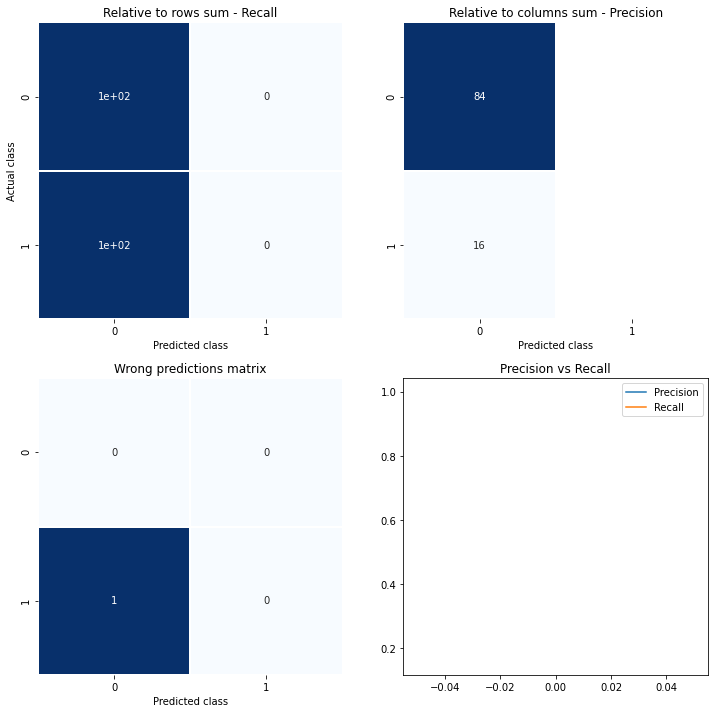

In [32]:
# Let's plot some metrics to have a better look at this
# This is to calculate where the wrong predictions go in every column
row_sums = my_model.cm.sum(axis = 1, keepdims = True)    # rows sums
column_sums = my_model.cm.sum(axis = 0, keepdims = True)    # columns sums
norm_cm = my_model.cm / row_sums                         # Division by the column sum
np.fill_diagonal(norm_cm, 0)                    # Fill the diagonal with 0s

# Plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12, 12))

sns.heatmap(my_model.cm / row_sums * 100, annot = True, linewidths = .1, cmap = "Blues", ax = ax1, cbar = False)
ax1.set_xlabel("Predicted class")
ax1.set_ylabel("Actual class")
ax1.set_title("Relative to rows sum - Recall")

sns.heatmap(my_model.cm / column_sums * 100, annot = True, linewidths = .1, cmap = "Blues", ax = ax2, cbar = False)
ax2.set_xlabel("Predicted class")
ax2.set_title("Relative to columns sum - Precision")

sns.heatmap(norm_cm, annot = True, linewidths = .1, cmap = "Blues", ax = ax3, cbar = False)
ax3.set_xlabel("Predicted class")
ax3.set_title("Wrong predictions matrix")

ax4.plot(my_model.thresholds, my_model.precisions[:-1], label = "Precision")
ax4.plot(my_model.thresholds, my_model.recalls[:-1], label = "Recall")
ax4.legend()
ax4.set_title("Precision vs Recall")

plt.show()

In [33]:
# Well, as we just saw, our current model is completely unable to predict any patient with asthma

In [34]:
# Let's try to do something with the data: 1) scale it, 2) 
dataset.model_data(split = .2, cv = 5, epochs = 1, scaler = True, balance = 1)

# Create new ml_model object and load the data (we'll use the same model to compare results just changing the data)
my_model_2 = md.ml_model(model)

# Load data
my_model_2.load_data(dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test, features_names, dataset.kfold)

# Train the model
my_model_2.ml_trainer()

In [35]:
# We can see that the batches are compensated now, although the score is much worse

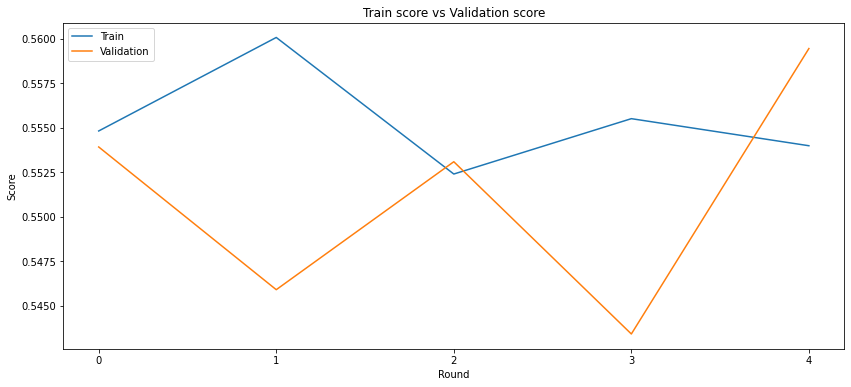

In [36]:
# Let's plot the results

plt.figure(figsize = (14, 6))
plt.plot(my_model_2.train_scores, label = "Train")
plt.plot(my_model_2.val_scores, label = "Validation")
plt.ylabel("Score")
plt.xlabel("Round")
plt.xticks(range(5))
plt.title("Train score vs Validation score")
plt.legend()
plt.show()

Train structure: {0.0: 50.0, 1.0: 50.0}
Test structure: {0.0: 84.1263940520446, 1.0: 15.87360594795539}
##################################################
Train score: 0.5550884955752212
Test score: 0.5613382899628253
##################################################
Confusion matrix
[[1252 1011]
 [ 169  258]]


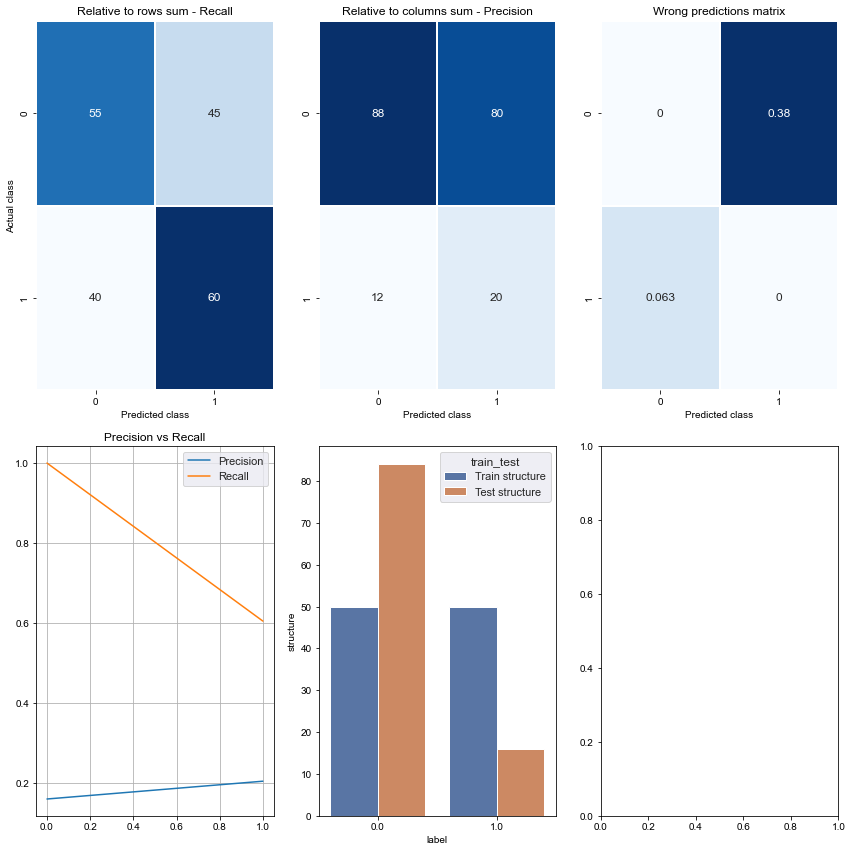

In [37]:
# With test data
my_model_2.ml_tester()

print("Train structure:", my_model_2.train_structure)
print("Test structure:", my_model_2.test_structure)
print("#" * 50)
print("Train score:", my_model_2.train_score)
print("Test score:", my_model_2.test_score)
print("#" * 50)
print("Confusion matrix")
print(my_model_2.cm)

structures = pd.DataFrame([my_model_2.train_structure, my_model_2.test_structure]).stack().reset_index()
structures.columns = ["train_test", "label", "structure"]
structures.train_test = structures.train_test.replace([0, 1], ["Train structure", "Test structure"])

# Let's plot some metrics to have a better look at this
# This is to calculate where the wrong predictions go in every column
row_sums = my_model_2.cm.sum(axis = 1, keepdims = True)    # rows sums
column_sums = my_model_2.cm.sum(axis = 0, keepdims = True)    # columns sums
norm_cm = my_model_2.cm / my_model_2.cm.sum()                         # Division by the column sum
np.fill_diagonal(norm_cm, 0)                    # Fill the diagonal with 0s

# Plot
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (12, 12))

sns.set_theme()

sns.heatmap(my_model_2.cm / row_sums * 100, annot = True, linewidths = .1, cmap = "Blues", ax = ax1, cbar = False)
ax1.set_xlabel("Predicted class")
ax1.set_ylabel("Actual class")
ax1.set_title("Relative to rows sum - Recall")

sns.heatmap(my_model_2.cm / column_sums * 100, annot = True, linewidths = .1, cmap = "Blues", ax = ax2, cbar = False)
ax2.set_xlabel("Predicted class")
ax2.set_title("Relative to columns sum - Precision")

sns.heatmap(norm_cm, annot = True, linewidths = .1, cmap = "Blues", ax = ax3, cbar = False)
ax3.set_xlabel("Predicted class")
ax3.set_title("Wrong predictions matrix")

ax4.plot(my_model_2.thresholds, my_model_2.precisions[:-1], label = "Precision")
ax4.plot(my_model_2.thresholds, my_model_2.recalls[:-1], label = "Recall")
ax4.legend()
ax4.set_title("Precision vs Recall")
ax4.grid()

sns.barplot(x = "label", y = "structure", hue = "train_test", data = structures, ax = ax5)

plt.tight_layout()
plt.show()

In [38]:
# Now, our model is predicting half of the participants to have asthma, what is quite imprecise too

### Random Forest

In [39]:
# Let's try with random forest

# Let's try this model with scaler and balancing data too

# Model
model = RandomForestClassifier(n_jobs = -1)

# Create new ml_model object and load the data (we'll use the same model to compare results just changing the data)
my_model_3 = md.ml_model(model)

# Load data
my_model_3.load_data(dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test, features_names, dataset.kfold)

# Train the model
my_model_3.ml_trainer()

# Model with test data
my_model_3.ml_tester()

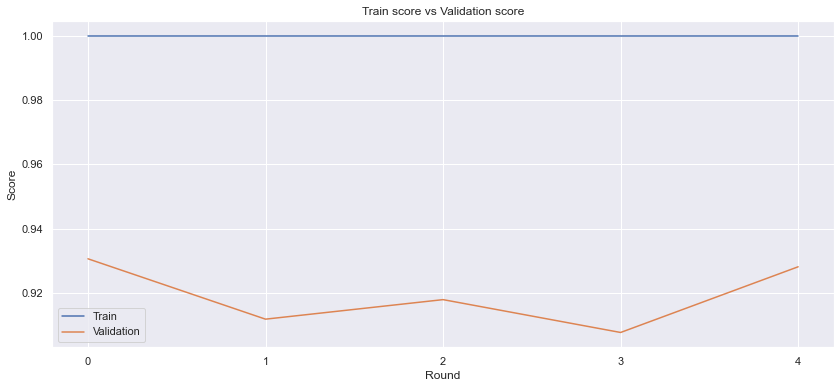

In [40]:
# Let's plot the results

plt.figure(figsize = (14, 6))
plt.plot(my_model_3.train_scores, label = "Train")
plt.plot(my_model_3.val_scores, label = "Validation")
plt.ylabel("Score")
plt.xlabel("Round")
plt.xticks(range(5))
plt.title("Train score vs Validation score")
plt.legend()
plt.show()

Train structure: {0.0: 50.0, 1.0: 50.0}
Test structure: {0.0: 84.1263940520446, 1.0: 15.87360594795539}
##################################################
Train score: 0.9856194690265486
Test score: 0.7973977695167286
##################################################
Confusion matrix
[[1252 1011]
 [ 169  258]]


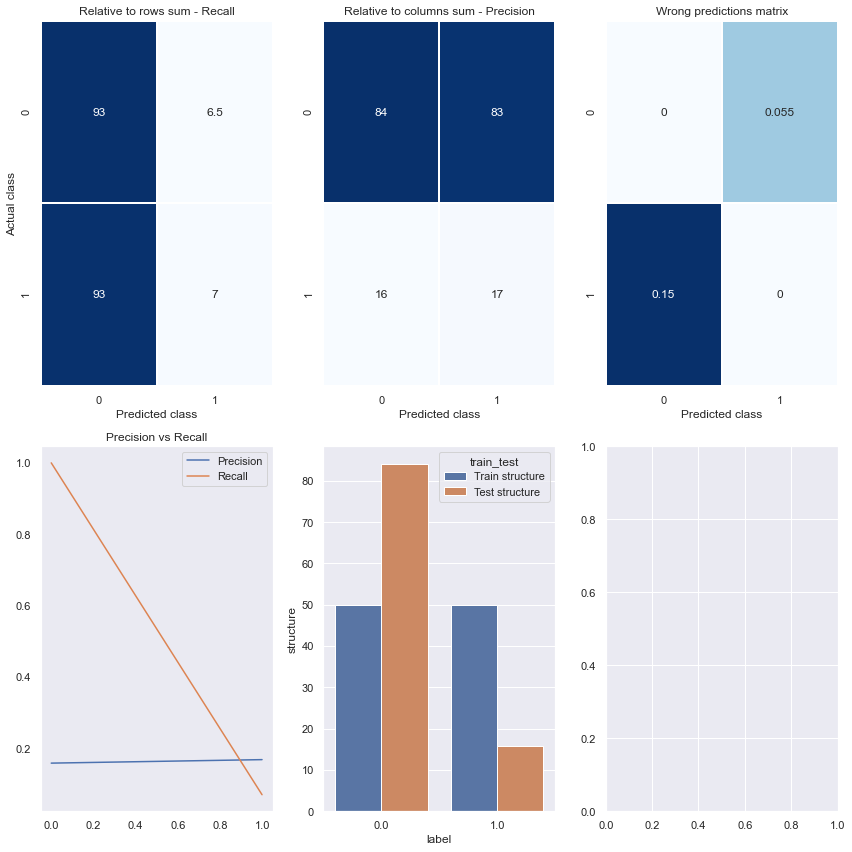

In [41]:
# With test data
my_model_3.ml_tester()

print("Train structure:", my_model_3.train_structure)
print("Test structure:", my_model_3.test_structure)
print("#" * 50)
print("Train score:", my_model_3.train_score)
print("Test score:", my_model_3.test_score)
print("#" * 50)
print("Confusion matrix")
print(my_model_2.cm)

structures = pd.DataFrame([my_model_3.train_structure, my_model_3.test_structure]).stack().reset_index()
structures.columns = ["train_test", "label", "structure"]
structures.train_test = structures.train_test.replace([0, 1], ["Train structure", "Test structure"])

# Let's plot some metrics to have a better look at this
# This is to calculate where the wrong predictions go in every column
row_sums = my_model_3.cm.sum(axis = 1, keepdims = True)    # rows sums
column_sums = my_model_3.cm.sum(axis = 0, keepdims = True)    # columns sums
norm_cm = my_model_3.cm / my_model_3.cm.sum()                         # Division by the column sum
np.fill_diagonal(norm_cm, 0)                    # Fill the diagonal with 0s

# Plot
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (12, 12))

sns.set_theme()

sns.heatmap(my_model_3.cm / row_sums * 100, annot = True, linewidths = .1, cmap = "Blues", ax = ax1, cbar = False)
ax1.set_xlabel("Predicted class")
ax1.set_ylabel("Actual class")
ax1.set_title("Relative to rows sum - Recall")

sns.heatmap(my_model_3.cm / column_sums * 100, annot = True, linewidths = .1, cmap = "Blues", ax = ax2, cbar = False)
ax2.set_xlabel("Predicted class")
ax2.set_title("Relative to columns sum - Precision")

sns.heatmap(norm_cm, annot = True, linewidths = .1, cmap = "Blues", ax = ax3, cbar = False)
ax3.set_xlabel("Predicted class")
ax3.set_title("Wrong predictions matrix")

ax4.plot(my_model_3.thresholds, my_model_3.precisions[:-1], label = "Precision")
ax4.plot(my_model_3.thresholds, my_model_3.recalls[:-1], label = "Recall")
ax4.legend()
ax4.set_title("Precision vs Recall")
ax4.grid()

sns.barplot(x = "label", y = "structure", hue = "train_test", data = structures, ax = ax5)

plt.tight_layout()
plt.show()

In [44]:
pd.Series(my_model.train_structure)

0.0    84.046114
1.0    15.953886
dtype: float64

## Neural net